In [36]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold


In [37]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

In [71]:
uvtools.plot.waterfall?

In [59]:
def load_data_cv():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    print(f"Dataset length: {len(dataset)}")
    X, y = dataset, labels
    n_features = (X.shape[1], X.shape[2])
    return X, y, n_features

def load_data():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    print(f"Dataset length: {len(dataset)}")
    X, y = dataset, labels
    print(type(X[1][1][1]))

    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    n_features = (X_train.shape[1], X_train.shape[2])
    # print(n_features)
    return X, y, X_train, y_train, X_test, y_test, n_features

def create_model(n_features):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=n_features))
    model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # fit the model
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, validation_split=0.2)

    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy: %.3f' % acc)

    # make predictions
    predictions = model.predict_classes(X_test)
    predictions = predictions.flatten()
    # model.summary()
    return history, acc, predictions


In [60]:
def get_faulty_predictions(predictions, labels):
    my_list = []
    for i, val in enumerate(predictions):
        if predictions[i] != labels[i]:
            my_list.append(i)
    return my_list

def print_stats(accs, faulty_predictions, predictions):
    print(f"Mean accuracy: {np.mean(accs)}")
    print(f"Standard dev.: {np.std(accs)}")
    l = []
    for val in faulty_predictions:
        l.append(predictions[val])
    print(f"0's (RFI misclassified as clean): {np.bincount(l)[0]}")
    print(f"1's (clean misclassified as RFI): {np.bincount(l)[1]}")

# def show_hist(my_list):
#     bins=np.linspace(0,1200,24)
#     print(f"Number of elements plotted: {len(my_list)}")
#     plt.hist(my_list, bins=bins)
#     plt.xlabel("index in dataset (<200 is clean)")
#     plt.ylabel("count")
#     plt.title("faulty predictions")
#     plt.show()

- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

# No Cross-validation

In [70]:
# playing with complex numbers
X, y, X_train, y_train, X_test, y_test, n_features = load_data()

print(X[1][10])

Dataset length: 1200
<class 'numpy.complex128'>
[  28.39310521 +27.21509584j  -52.44767149 -54.33617906j
   12.09254876-121.15997632j ...  210.00648617 +40.71404189j
 -211.47124003 -98.51236955j  -98.88588695+103.0698979j ]


Dataset length: 1200
<class 'numpy.complex128'>
Train on 768 samples, validate on 192 samples
Epoch 1/150
768/768 [==============================] - 2s 3ms/sample - loss: 283.5894 - accuracy: 0.9362 - val_loss: 6.6413 - val_accuracy: 0.9844
Epoch 2/150
768/768 [==============================] - 1s 747us/sample - loss: 17.9722 - accuracy: 0.9948 - val_loss: 1.1913 - val_accuracy: 0.9948
Epoch 3/150
768/768 [==============================] - 1s 700us/sample - loss: 69.7844 - accuracy: 0.9948 - val_loss: 15.5714 - val_accuracy: 0.9792
Epoch 4/150
768/768 [==============================] - 1s 665us/sample - loss: 251.9385 - accuracy: 0.9883 - val_loss: 4.4054e-13 - val_accuracy: 1.0000
Epoch 5/150
768/768 [==============================] - 1s 1ms/sample - loss: 0.0840 - accuracy: 0.9987 - val_loss: 7.5394e-13 - val_accuracy: 1.0000
Epoch 6/150
768/768 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.3300e-15 - val_accuracy: 1.0000
Epoch 7

768/768 [==============================] - 1s 801us/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 54/150
768/768 [==============================] - 1s 752us/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 55/150
768/768 [==============================] - 1s 863us/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 56/150
768/768 [==============================] - 1s 722us/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 57/150
768/768 [==============================] - 1s 848us/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 58/150
768/768 [==============================] - 1s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 59/150
768/768 [==============================] - 1s 1ms/sample - loss: 0

Epoch 106/150
768/768 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 107/150
768/768 [==============================] - 1s 900us/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 108/150
768/768 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 109/150
768/768 [==============================] - 1s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 110/150
768/768 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 111/150
768/768 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3047e-15 - val_accuracy: 1.0000
Epoch 112/150
768/768 [==============================] - 1s 1ms/samp

Test Accuracy: 0.992
Mean accuracy: 0.9916666746139526
Standard dev.: 0.0
0's (RFI misclassified as clean): 0
1's (clean misclassified as RFI): 2


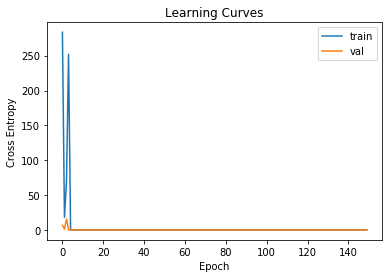

In [63]:
X, y, X_train, y_train, X_test, y_test, n_features = load_data()

faulty_predictions = []
accs = []
model = None
model = create_model(n_features)
history, acc, predictions = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
accs.append(acc)
faulty_predictions.extend(get_faulty_predictions(predictions, y_test))

print_stats(accs, faulty_predictions, predictions)

plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

## Visualize faulty predictions

Predicted: 1


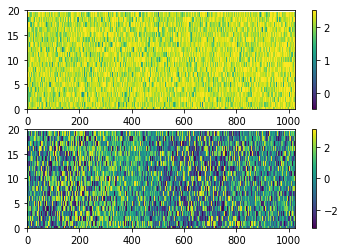

396


In [33]:
for i, val in enumerate(X):
    if i in faulty_predictions:
        print(f'Predicted: {predictions[i]}')
        plot_one_vis(val, 20)
print(len(predictions))

# Stratified K-fold Cross-validation

In [30]:
n_splits = 3
X, y, n_features = load_data_cv()
skf = StratifiedKFold(n_splits, shuffle=True)

accs = []
faulty_predictions=[]

for i in range(10):
    print(f"Run {i}")
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # print(len(X[test_index]), len(y[train_index]))
        print("Running Fold", i+1, "/", n_splits)
        model = None # clear the NN
        model = create_model(n_features)
        history, acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])
        accs.append(acc)
        faulty_predictions.extend(get_faulty_predictions(predictions, y[test_index]))

print_stats(accs, faulty_predictions, predictions)

Dataset length: 1200
Run 0
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 20.8598 - accuracy: 0.9150
Epoch 2/150
800/800 [==============================] - 1s 693us/sample - loss: 3.8349 - accuracy: 0.9912
Epoch 3/150
800/800 [==============================] - 1s 761us/sample - loss: 0.0894 - accuracy: 0.9987
Epoch 4/150
800/800 [==============================] - 1s 737us/sample - loss: 8.6077e-04 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 568us/sample - loss: 8.5629e-04 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 522us/sample - loss: 8.5284e-04 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 551us/sample - loss: 8.5167e-04 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 540us/sample - loss: 8.5108e-04 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 590us/sample - l

800/800 [==============================] - 0s 581us/sample - loss: 7.9284e-04 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 578us/sample - loss: 7.9122e-04 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 592us/sample - loss: 7.8993e-04 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 573us/sample - loss: 7.8872e-04 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 608us/sample - loss: 7.8733e-04 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 570us/sample - loss: 7.8587e-04 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 559us/sample - loss: 7.8549e-04 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 713us/sample - loss: 7.8311e-04 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 641us/sample - loss: 7.8297e-04 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 1s 733us/sample - loss: 6.6975e-04 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 627us/sample - loss: 6.6778e-04 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.985
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 43.1190 - accuracy: 0.9500
Epoch 2/150
800/800 [==============================] - 0s 617us/sample - loss: 1.1896 - accuracy: 0.9975
Epoch 3/150
800/800 [==============================] - 0s 607us/sample - loss: 0.0332 - accuracy: 0.9987
Epoch 4/150
800/800 [==============================] - 1s 724us/sample - loss: 5.2485e-24 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 604us/sample - loss: 5.4590e-24 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 596us/sample - loss: 5.4651e-24 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 593us/sample - loss: 5.4692e-24 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 594us/sample - loss: 5.4702e-24 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 599us/sample - loss: 5

800/800 [==============================] - 0s 595us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 615us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 611us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 590us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 588us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 629us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 591us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 595us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 595us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 0s 596us/sample - loss: 5.4696e-24 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 572us/sample - loss: 5.4696e-24 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.990
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 122.7099 - accuracy: 0.9450
Epoch 2/150
800/800 [==============================] - 0s 594us/sample - loss: 4.2981 - accuracy: 0.9900
Epoch 3/150
800/800 [==============================] - 0s 619us/sample - loss: 2.3173 - accuracy: 0.9950
Epoch 4/150
800/800 [==============================] - 0s 606us/sample - loss: 2.0859 - accuracy: 0.9925
Epoch 5/150
800/800 [==============================] - 0s 578us/sample - loss: 1.4786 - accuracy: 0.9925
Epoch 6/150
800/800 [==============================] - 0s 587us/sample - loss: 0.5724 - accuracy: 0.9962
Epoch 7/150
800/800 [==============================] - 0s 589us/sample - loss: 1.0885 - accuracy: 0.9962
Epoch 8/150
800/800 [==============================] - 0s 594us/sample - loss: 4.9395 - accuracy: 0.9950
Epoch 9/150
800/800 [==============================] - 1s 630us/sample - loss: 1.2371 - accuracy: 0

800/800 [==============================] - 1s 625us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 699us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 637us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 727us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 84/150
800/800 [==============================] - 1s 636us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 85/150
800/800 [==============================] - 1s 643us/sample - loss: 0.0034 - accuracy: 1.0000
Epoch 86/150
800/800 [==============================] - 1s 1ms/sa

Test Accuracy: 0.988
Run 1
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 3ms/sample - loss: 92.5894 - accuracy: 0.8888
Epoch 2/150
800/800 [==============================] - 0s 584us/sample - loss: 14.0393 - accuracy: 0.9862
Epoch 3/150
800/800 [==============================] - 0s 586us/sample - loss: 0.2345 - accuracy: 0.9962
Epoch 4/150
800/800 [==============================] - 0s 599us/sample - loss: 0.0060 - accuracy: 0.9987
Epoch 5/150
800/800 [==============================] - 0s 611us/sample - loss: 0.0054 - accuracy: 0.9987
Epoch 6/150
800/800 [==============================] - 1s 650us/sample - loss: 0.0050 - accuracy: 0.9987
Epoch 7/150
800/800 [==============================] - 1s 713us/sample - loss: 0.0047 - accuracy: 0.9987
Epoch 8/150
800/800 [==============================] - 1s 670us/sample - loss: 0.0044 - accuracy: 0.9987
Epoch 9/150
800/800 [==============================] - 1s 728us/sample - loss: 0.0043 - accur

800/800 [==============================] - 1s 626us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 626us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 640us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 671us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 601us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 620us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 610us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 84/150
800/800 [==============================] - 0s 608us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 85/150
800/800 [==============================] - 1s 631us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 86/150
800/800 [==============================] - 0s 

Test Accuracy: 0.988
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 3ms/sample - loss: 688.7411 - accuracy: 0.9262
Epoch 2/150
800/800 [==============================] - 1s 892us/sample - loss: 11.7413 - accuracy: 0.9950
Epoch 3/150
800/800 [==============================] - 1s 773us/sample - loss: 0.1637 - accuracy: 0.9987
Epoch 4/150
800/800 [==============================] - 1s 625us/sample - loss: 2.7079e-15 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 606us/sample - loss: 1.2317e-14 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 1s 628us/sample - loss: 2.5244e-14 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 586us/sample - loss: 2.6034e-14 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 761us/sample - loss: 2.6064e-14 - accuracy: 1.0000 - loss: 3.2580e-14 - accuracy: 1.
Epoch 9/150
800/800 [=======================

800/800 [==============================] - 0s 604us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 75/150
800/800 [==============================] - 0s 586us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 569us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 599us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 604us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 600us/sample - loss: 2.6066e-14 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 577us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 596us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 598us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 83/150
800/800 [=

800/800 [==============================] - 1s 700us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 149/150
800/800 [==============================] - 1s 632us/sample - loss: 2.6065e-14 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 697us/sample - loss: 2.6065e-14 - accuracy: 1.0000
400/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.985
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 3s 4ms/sample - loss: 156.5619 - accuracy: 0.9425
Epoch 2/150
800/800 [==============================] - 1s 758us/sample - loss: 15.5047 - accuracy: 0.9887
Epoch 3/150
800/800 [==============================] - 1s 774us/sample - loss: 0.2506 - accuracy: 0.9987
Epoch 4/150
800/800 [==============================] - 1s 633us/sample - loss: 2.0877e-10 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 1s 694us/sample - loss: 1.2176e-10 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 1s 985us/sample - loss: 1.0677e-10 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 1s 751us/sample - loss: 8.0139e-11 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 761us/sample - loss: 7.1742e-11 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 680us/sample - loss:

800/800 [==============================] - 1s 678us/sample - loss: 3.0593e-12 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 648us/sample - loss: 3.0083e-12 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 622us/sample - loss: 2.9481e-12 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 662us/sample - loss: 2.8881e-12 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 647us/sample - loss: 2.8513e-12 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 614us/sample - loss: 2.7814e-12 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 618us/sample - loss: 2.7490e-12 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 672us/sample - loss: 2.6808e-12 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 643us/sample - loss: 2.6370e-12 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 1s 944us/sample - loss: 1.1123e-12 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 1ms/sample - loss: 1.1076e-12 - accuracy: 1.0000
400/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.988
Run 2
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 260.1210 - accuracy: 0.9250
Epoch 2/150
800/800 [==============================] - 1s 638us/sample - loss: 7.1271 - accuracy: 0.9925
Epoch 3/150
800/800 [==============================] - 1s 640us/sample - loss: 15.5472 - accuracy: 0.9937
Epoch 4/150
800/800 [==============================] - 1s 643us/sample - loss: 7.9706 - accuracy: 0.9962
Epoch 5/150
800/800 [==============================] - 1s 632us/sample - loss: 8.1596 - accuracy: 0.9937
Epoch 6/150
800/800 [==============================] - 1s 664us/sample - loss: 0.1807 - accuracy: 0.9987
Epoch 7/150
800/800 [==============================] - 1s 681us/sample - loss: 3.2904e-13 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 651us/sample - loss: 1.6283e-13 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 653us/sample - loss: 1.516

800/800 [==============================] - 1s 813us/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 659us/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 1ms/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 2s 2ms/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 1ms/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 1ms/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 1ms/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 1ms/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 618us/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 84/150
800/800 [=============

800/800 [==============================] - 0s 555us/sample - loss: 1.4996e-13 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 543us/sample - loss: 1.4996e-13 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.988
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 210.0015 - accuracy: 0.9250
Epoch 2/150
800/800 [==============================] - 0s 578us/sample - loss: 12.2613 - accuracy: 0.9937
Epoch 3/150
800/800 [==============================] - 0s 596us/sample - loss: 0.7059 - accuracy: 0.9975
Epoch 4/150
800/800 [==============================] - 0s 595us/sample - loss: 9.4846e-15 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 1s 711us/sample - loss: 2.5579e-14 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 615us/sample - loss: 5.5696e-14 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 601us/sample - loss: 5.7142e-14 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 562us/sample - loss: 5.7165e-14 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 566us/sample - loss:

Epoch 75/150
800/800 [==============================] - 1s 642us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 638us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 650us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 624us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 640us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 676us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 639us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 621us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 679us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 84/1

800/800 [==============================] - 1s 666us/sample - loss: 5.7167e-14 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 627us/sample - loss: 5.7167e-14 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.983
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 3ms/sample - loss: 22.2055 - accuracy: 0.9237
Epoch 2/150
800/800 [==============================] - 1s 677us/sample - loss: 33.5621 - accuracy: 0.9725
Epoch 3/150
800/800 [==============================] - 1s 656us/sample - loss: 2.2213 - accuracy: 0.9962
Epoch 4/150
800/800 [==============================] - 1s 656us/sample - loss: 0.1268 - accuracy: 0.9975
Epoch 5/150
800/800 [==============================] - 1s 887us/sample - loss: 0.1362 - accuracy: 0.9987
Epoch 6/150
800/800 [==============================] - 1s 799us/sample - loss: 8.3993e-04 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 1s 710us/sample - loss: 8.3972e-04 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 916us/sample - loss: 8.3937e-04 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 950us/sample - loss: 8.3902e-

800/800 [==============================] - 1s 1ms/sample - loss: 7.8318e-04 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 1ms/sample - loss: 7.8112e-04 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 1ms/sample - loss: 7.7995e-04 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 682us/sample - loss: 7.7844e-04 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 675us/sample - loss: 7.7715e-04 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 684us/sample - loss: 7.7579e-04 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 647us/sample - loss: 7.7447e-04 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 660us/sample - loss: 7.7313e-04 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 673us/sample - loss: 7.7155e-04 - accuracy: 1.0000
Epoch 84/150
800/800 [=======

800/800 [==============================] - 0s 598us/sample - loss: 6.5931e-04 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 602us/sample - loss: 6.5770e-04 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 1.000
Run 3
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 3s 3ms/sample - loss: 74.7653 - accuracy: 0.9050
Epoch 2/150
800/800 [==============================] - 0s 589us/sample - loss: 49.8857 - accuracy: 0.9837
Epoch 3/150
800/800 [==============================] - 0s 584us/sample - loss: 5.9617 - accuracy: 0.9950
Epoch 4/150
800/800 [==============================] - 0s 613us/sample - loss: 5.9944e-27 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 618us/sample - loss: 1.0264e-11 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 606us/sample - loss: 1.9389e-08 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 1s 638us/sample - loss: 7.1016e-08 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 596us/sample - loss: 4.2662e-08 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 603us/sample - 

800/800 [==============================] - 1s 1ms/sample - loss: 7.4552e-10 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 930us/sample - loss: 7.3202e-10 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 977us/sample - loss: 7.1487e-10 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 900us/sample - loss: 6.9898e-10 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 644us/sample - loss: 6.8596e-10 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 651us/sample - loss: 6.7209e-10 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 668us/sample - loss: 6.5787e-10 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 672us/sample - loss: 6.4562e-10 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 656us/sample - loss: 6.3286e-10 - accuracy: 1.0000
Epoch 84/150
800/800 [===

800/800 [==============================] - 1s 746us/sample - loss: 2.1110e-10 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 1ms/sample - loss: 2.0864e-10 - accuracy: 1.0000
400/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.978
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 3s 3ms/sample - loss: 26.8380 - accuracy: 0.9287
Epoch 2/150
800/800 [==============================] - 1s 626us/sample - loss: 8.2381 - accuracy: 0.9737
Epoch 3/150
800/800 [==============================] - 1s 722us/sample - loss: 0.3207 - accuracy: 0.9912
Epoch 4/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.1560 - accuracy: 0.9975
Epoch 5/150
800/800 [==============================] - 1s 1ms/sample - loss: 8.4636e-04 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 1s 1ms/sample - loss: 8.4582e-04 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 624us/sample - loss: 0.0021 - accuracy: 0.9987
Epoch 8/150
800/800 [==============================] - 0s 604us/sample - loss: 0.0912 - accuracy: 0.9987
Epoch 9/150
800/800 [==============================] - 0s 600us/sample - loss: 8.6752e-20 - accura

800/800 [==============================] - 0s 614us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 662us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 609us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 596us/sample - loss: 8.7338e-20 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 602us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 603us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 963us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 1ms/sample - loss: 8.7338e-20 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 798us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 84/150
800/800 [===

800/800 [==============================] - 0s 618us/sample - loss: 8.7342e-20 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 1ms/sample - loss: 8.7342e-20 - accuracy: 1.0000
400/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.983
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 107.2345 - accuracy: 0.9225
Epoch 2/150
800/800 [==============================] - 0s 589us/sample - loss: 75.4620 - accuracy: 0.9825
Epoch 3/150
800/800 [==============================] - 0s 586us/sample - loss: 49.9277 - accuracy: 0.9862
Epoch 4/150
800/800 [==============================] - 0s 584us/sample - loss: 11.5687 - accuracy: 0.9887
Epoch 5/150
800/800 [==============================] - 0s 594us/sample - loss: 0.5001 - accuracy: 0.9987
Epoch 6/150
800/800 [==============================] - 0s 587us/sample - loss: 0.6167 - accuracy: 0.9962
Epoch 7/150
800/800 [==============================] - 0s 590us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 585us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 593us/sample - loss: 0.0000e+0

800/800 [==============================] - 0s 596us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 958us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 84/150
800/800 [===============

800/800 [==============================] - 0s 597us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 583us/sample - loss: 0.0000e+00 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.980
Run 4
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 449.7852 - accuracy: 0.8750
Epoch 2/150
800/800 [==============================] - 0s 581us/sample - loss: 17.7305 - accuracy: 0.9950
Epoch 3/150
800/800 [==============================] - 0s 588us/sample - loss: 5.5245 - accuracy: 0.9975
Epoch 4/150
800/800 [==============================] - 0s 578us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 624us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 596us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 577us/sample - loss: 0.0025 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 577us/sample - loss: 0.0025 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 579us/sample - loss: 0.0025 - accu

800/800 [==============================] - 0s 586us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 584us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 577us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 582us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 580us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 575us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 589us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 84/150
800/800 [==============================] - 0s 591us/sample - loss: 0.0023 - accuracy: 1.0000
Epoch 85/150
800/800 [==============================] - 0s 585us/sample - loss: 0.0023 - accuracy: 1.0000
Epoch 86/150
800/800 [==============================] - 0s 

Test Accuracy: 0.990
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 104.5715 - accuracy: 0.9275
Epoch 2/150
800/800 [==============================] - 0s 570us/sample - loss: 37.0651 - accuracy: 0.9912
Epoch 3/150
800/800 [==============================] - 0s 584us/sample - loss: 0.2636 - accuracy: 0.9987
Epoch 4/150
800/800 [==============================] - 0s 571us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 564us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 556us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 564us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 567us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 568us/sample - loss:

800/800 [==============================] - 1s 821us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 624us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 615us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 632us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 622us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 583us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 796us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 719us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 84/150
800/800 [===

800/800 [==============================] - 1s 839us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 584us/sample - loss: 0.0000e+00 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.985
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 188.2580 - accuracy: 0.9362
Epoch 2/150
800/800 [==============================] - 0s 590us/sample - loss: 16.8940 - accuracy: 0.9962
Epoch 3/150
800/800 [==============================] - 0s 590us/sample - loss: 4.9997 - accuracy: 0.9950
Epoch 4/150
800/800 [==============================] - 0s 618us/sample - loss: 32.1228 - accuracy: 0.9937
Epoch 5/150
800/800 [==============================] - 0s 605us/sample - loss: 7.7188 - accuracy: 0.9875
Epoch 6/150
800/800 [==============================] - 0s 603us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 580us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 597us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 611us/sample - loss: 0.0000

800/800 [==============================] - 0s 618us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 75/150
800/800 [==============================] - 0s 600us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 673us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 834us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 681us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 623us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 590us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 599us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 585us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/150
800/800 [=

800/800 [==============================] - 1s 877us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 149/150
800/800 [==============================] - 1s 685us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 724us/sample - loss: 0.0000e+00 - accuracy: 1.0000
400/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.990
Run 5
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 146.3130 - accuracy: 0.9087
Epoch 2/150
800/800 [==============================] - 0s 598us/sample - loss: 27.9118 - accuracy: 0.9750
Epoch 3/150
800/800 [==============================] - 0s 605us/sample - loss: 2.8817 - accuracy: 0.9937
Epoch 4/150
800/800 [==============================] - 0s 598us/sample - loss: 5.9261e-05 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 616us/sample - loss: 6.0258e-12 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 601us/sample - loss: 3.2319e-13 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 597us/sample - loss: 1.7158e-13 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 602us/sample - loss: 1.7093e-13 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 593us/sample -

800/800 [==============================] - 1s 693us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 673us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 629us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 651us/sample - loss: 1.7086e-13 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 643us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 679us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 679us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 632us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 646us/sample - loss: 1.7086e-13 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 1s 668us/sample - loss: 1.7085e-13 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 764us/sample - loss: 1.7085e-13 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.983
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 230.9537 - accuracy: 0.9225
Epoch 2/150
800/800 [==============================] - 1s 654us/sample - loss: 3.7872 - accuracy: 0.9950
Epoch 3/150
800/800 [==============================] - 1s 672us/sample - loss: 0.3335 - accuracy: 0.9962
Epoch 4/150
800/800 [==============================] - 1s 629us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 1s 631us/sample - loss: 6.3603e-07 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 1s 655us/sample - loss: 0.0273 - accuracy: 0.9987
Epoch 7/150
800/800 [==============================] - 1s 677us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 641us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 631us/sample - loss: 0.00

800/800 [==============================] - 1s 670us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 765us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 744us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 795us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 640us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 636us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 782us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 658us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 84/150
800/800 [===

800/800 [==============================] - 0s 575us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 578us/sample - loss: 0.0000e+00 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.985
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 137.9080 - accuracy: 0.9350
Epoch 2/150
800/800 [==============================] - 0s 573us/sample - loss: 5.3990 - accuracy: 0.9812
Epoch 3/150
800/800 [==============================] - 0s 599us/sample - loss: 2.3812 - accuracy: 0.9862
Epoch 4/150
800/800 [==============================] - 0s 602us/sample - loss: 0.4162 - accuracy: 0.9950
Epoch 5/150
800/800 [==============================] - 0s 567us/sample - loss: 0.3375 - accuracy: 0.9962
Epoch 6/150
800/800 [==============================] - 0s 600us/sample - loss: 60.6760 - accuracy: 0.9850
Epoch 7/150
800/800 [==============================] - 0s 586us/sample - loss: 86.2185 - accuracy: 0.9875
Epoch 8/150
800/800 [==============================] - 0s 602us/sample - loss: 90.0487 - accuracy: 0.9912
Epoch 9/150
800/800 [==============================] - 0s 569us/sample - loss: 10.4626 - accurac

800/800 [==============================] - 0s 584us/sample - loss: 7.6976e-04 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 643us/sample - loss: 7.6862e-04 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 591us/sample - loss: 7.6749e-04 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 608us/sample - loss: 7.6596e-04 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 581us/sample - loss: 7.6511e-04 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 681us/sample - loss: 7.6339e-04 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 663us/sample - loss: 7.6325e-04 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 687us/sample - loss: 7.6080e-04 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 606us/sample - loss: 7.5950e-04 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 0s 566us/sample - loss: 6.5163e-04 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 562us/sample - loss: 6.5041e-04 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.985
Run 6
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 3ms/sample - loss: 136.3776 - accuracy: 0.9337
Epoch 2/150
800/800 [==============================] - 0s 566us/sample - loss: 8.9111 - accuracy: 0.9900
Epoch 3/150
800/800 [==============================] - 0s 561us/sample - loss: 13.0566 - accuracy: 0.9987
Epoch 4/150
800/800 [==============================] - 0s 568us/sample - loss: 0.1831 - accuracy: 0.9975
Epoch 5/150
800/800 [==============================] - 0s 571us/sample - loss: 8.5940e-04 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 598us/sample - loss: 0.0011 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 562us/sample - loss: 8.5849e-04 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 580us/sample - loss: 8.5824e-04 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 613us/sample - loss: 8

800/800 [==============================] - 0s 552us/sample - loss: 8.0869e-04 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 556us/sample - loss: 8.0762e-04 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 558us/sample - loss: 8.0630e-04 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 567us/sample - loss: 8.0509e-04 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 559us/sample - loss: 8.0393e-04 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 616us/sample - loss: 8.0270e-04 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 590us/sample - loss: 8.0139e-04 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 593us/sample - loss: 8.0017e-04 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 676us/sample - loss: 7.9921e-04 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 0s 580us/sample - loss: 6.9329e-04 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 592us/sample - loss: 6.9150e-04 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.983
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 429.2363 - accuracy: 0.9388
Epoch 2/150
800/800 [==============================] - 0s 560us/sample - loss: 0.5677 - accuracy: 0.9937
Epoch 3/150
800/800 [==============================] - 0s 569us/sample - loss: 4.3955 - accuracy: 0.9975
Epoch 4/150
800/800 [==============================] - 0s 559us/sample - loss: 0.3080 - accuracy: 0.9962
Epoch 5/150
800/800 [==============================] - 0s 585us/sample - loss: 0.0961 - accuracy: 0.9987
Epoch 6/150
800/800 [==============================] - 0s 612us/sample - loss: 3.1286e-06 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 1s 793us/sample - loss: 3.8438e-24 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 595us/sample - loss: 4.0056e-24 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 562us/sample - loss: 4.0075e-

800/800 [==============================] - 1s 763us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 1s 691us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 576us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 578us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 568us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 585us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 579us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 587us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 695us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 1s 644us/sample - loss: 4.0077e-24 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 1ms/sample - loss: 4.0077e-24 - accuracy: 1.0000
400/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.990
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 4s 5ms/sample - loss: 129.3122 - accuracy: 0.8763
Epoch 2/150
800/800 [==============================] - 1s 1ms/sample - loss: 79.7477 - accuracy: 0.9425
Epoch 3/150
800/800 [==============================] - 1s 827us/sample - loss: 22.9991 - accuracy: 0.9675
Epoch 4/150
800/800 [==============================] - 1s 697us/sample - loss: 15.5666 - accuracy: 0.9688
Epoch 5/150
800/800 [==============================] - 0s 619us/sample - loss: 5.8469 - accuracy: 0.9800
Epoch 6/150
800/800 [==============================] - 0s 624us/sample - loss: 1.9679 - accuracy: 0.9887
Epoch 7/150
800/800 [==============================] - 1s 630us/sample - loss: 5.5476 - accuracy: 0.9937
Epoch 8/150
800/800 [==============================] - 1s 661us/sample - loss: 2.0983 - accuracy: 0.9950
Epoch 9/150
800/800 [==============================] - 1s 634us/sample - loss: 5.9843 - accuracy: 

800/800 [==============================] - 0s 611us/sample - loss: 0.0152 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 613us/sample - loss: 0.0150 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 595us/sample - loss: 0.0148 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 607us/sample - loss: 0.0147 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 634us/sample - loss: 0.0145 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 653us/sample - loss: 0.0143 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 598us/sample - loss: 0.0142 - accuracy: 1.0000
Epoch 84/150
800/800 [==============================] - 1s 676us/sample - loss: 0.0140 - accuracy: 1.0000
Epoch 85/150
800/800 [==============================] - 0s 607us/sample - loss: 0.0139 - accuracy: 1.0000
Epoch 86/150
800/800 [==============================] - 0s 

Test Accuracy: 0.970
Run 7
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 22.1361 - accuracy: 0.9550
Epoch 2/150
800/800 [==============================] - 0s 616us/sample - loss: 126.1994 - accuracy: 0.9925
Epoch 3/150
800/800 [==============================] - 0s 611us/sample - loss: 144.0844 - accuracy: 0.9912
Epoch 4/150
800/800 [==============================] - 0s 612us/sample - loss: 42.3787 - accuracy: 0.9950
Epoch 5/150
800/800 [==============================] - 1s 651us/sample - loss: 8.1417e-39 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 621us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 612us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 614us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 0s 623us/sample - 

800/800 [==============================] - 0s 622us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 608us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 773us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 628us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 1s 680us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 590us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 595us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 599us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 84/150
800/800 [===

800/800 [==============================] - 1s 648us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 592us/sample - loss: 0.0000e+00 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.998
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 111.4396 - accuracy: 0.9225
Epoch 2/150
800/800 [==============================] - 1s 669us/sample - loss: 9.3482 - accuracy: 0.9862
Epoch 3/150
800/800 [==============================] - 0s 610us/sample - loss: 8.0497 - accuracy: 0.9937
Epoch 4/150
800/800 [==============================] - 0s 599us/sample - loss: 0.8371 - accuracy: 0.9975
Epoch 5/150
800/800 [==============================] - 0s 600us/sample - loss: 0.2519 - accuracy: 0.9987
Epoch 6/150
800/800 [==============================] - 1s 640us/sample - loss: 0.1870 - accuracy: 0.9987
Epoch 7/150
800/800 [==============================] - 0s 593us/sample - loss: 0.0952 - accuracy: 0.9987
Epoch 8/150
800/800 [==============================] - 0s 588us/sample - loss: 0.0381 - accuracy: 0.9987
Epoch 9/150
800/800 [==============================] - 0s 591us/sample - loss: 0.0032 - accuracy: 0

800/800 [==============================] - 1s 633us/sample - loss: 1.0220e-09 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 587us/sample - loss: 1.0011e-09 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 592us/sample - loss: 9.8181e-10 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 678us/sample - loss: 9.5372e-10 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 641us/sample - loss: 9.3436e-10 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 616us/sample - loss: 9.1551e-10 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 606us/sample - loss: 9.0272e-10 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 1s 1ms/sample - loss: 8.7583e-10 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 715us/sample - loss: 8.5813e-10 - accuracy: 1.0000
Epoch 84/150
800/800 [===

800/800 [==============================] - 0s 573us/sample - loss: 2.8229e-10 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 587us/sample - loss: 2.7777e-10 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.980
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 3s 4ms/sample - loss: 265.6534 - accuracy: 0.9212
Epoch 2/150
800/800 [==============================] - 1s 636us/sample - loss: 1.6688 - accuracy: 0.9975
Epoch 3/150
800/800 [==============================] - 1s 715us/sample - loss: 2.6917e-15 - accuracy: 1.0000
Epoch 4/150
800/800 [==============================] - 1s 766us/sample - loss: 4.9058e-10 - accuracy: 1.0000
Epoch 5/150
800/800 [==============================] - 0s 618us/sample - loss: 1.2024e-09 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 1s 673us/sample - loss: 1.4408e-09 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 1s 722us/sample - loss: 1.4583e-09 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 619us/sample - loss: 1.4590e-09 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 837us/sample - lo

800/800 [==============================] - 0s 609us/sample - loss: 1.1599e-09 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 614us/sample - loss: 1.1526e-09 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 1s 715us/sample - loss: 1.1463e-09 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 610us/sample - loss: 1.1406e-09 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 645us/sample - loss: 1.1324e-09 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 600us/sample - loss: 1.1246e-09 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 1s 630us/sample - loss: 1.1180e-09 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 617us/sample - loss: 1.1114e-09 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 624us/sample - loss: 1.1045e-09 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 1s 701us/sample - loss: 6.3379e-10 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 1s 643us/sample - loss: 6.2474e-10 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.988
Run 8
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 245.0315 - accuracy: 0.9438
Epoch 2/150
800/800 [==============================] - 1s 658us/sample - loss: 26.3556 - accuracy: 0.9937
Epoch 3/150
800/800 [==============================] - 1s 646us/sample - loss: 4.1419 - accuracy: 0.9962
Epoch 4/150
800/800 [==============================] - 1s 682us/sample - loss: 47.6636 - accuracy: 0.9962
Epoch 5/150
800/800 [==============================] - 1s 636us/sample - loss: 1.8140e-25 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 1s 709us/sample - loss: 0.2848 - accuracy: 0.9987
Epoch 7/150
800/800 [==============================] - 1s 679us/sample - loss: 2.7946e-19 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 694us/sample - loss: 11.6688 - accuracy: 0.9950
Epoch 9/150
800/800 [==============================] - 1s 775us/sample - loss: 10.

800/800 [==============================] - 1s 653us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 588us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 592us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 609us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 597us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 596us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 584us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 611us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 1s 628us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 0s 580us/sample - loss: 1.8993e-26 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 598us/sample - loss: 1.8993e-26 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.993
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 214.0475 - accuracy: 0.8612
Epoch 2/150
800/800 [==============================] - 0s 603us/sample - loss: 55.7249 - accuracy: 0.9075
Epoch 3/150
800/800 [==============================] - 0s 574us/sample - loss: 31.1609 - accuracy: 0.9475
Epoch 4/150
800/800 [==============================] - 1s 627us/sample - loss: 10.3755 - accuracy: 0.9625
Epoch 5/150
800/800 [==============================] - 0s 601us/sample - loss: 3.5485 - accuracy: 0.9737
Epoch 6/150
800/800 [==============================] - 0s 595us/sample - loss: 3.3295 - accuracy: 0.9800
Epoch 7/150
800/800 [==============================] - 0s 586us/sample - loss: 1.4307 - accuracy: 0.9862
Epoch 8/150
800/800 [==============================] - 0s 609us/sample - loss: 1.1737 - accuracy: 0.9887
Epoch 9/150
800/800 [==============================] - 0s 605us/sample - loss: 0.5005 - accuracy

800/800 [==============================] - 0s 599us/sample - loss: 0.0197 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 591us/sample - loss: 0.0194 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 601us/sample - loss: 0.0192 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 595us/sample - loss: 0.0190 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 575us/sample - loss: 0.0187 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 604us/sample - loss: 0.0185 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 596us/sample - loss: 0.0183 - accuracy: 1.0000
Epoch 84/150
800/800 [==============================] - 0s 598us/sample - loss: 0.0181 - accuracy: 1.0000
Epoch 85/150
800/800 [==============================] - 0s 571us/sample - loss: 0.0178 - accuracy: 1.0000
Epoch 86/150
800/800 [==============================] - 0s 

Test Accuracy: 0.950
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 3ms/sample - loss: 252.1893 - accuracy: 0.9100
Epoch 2/150
800/800 [==============================] - 1s 674us/sample - loss: 23.1100 - accuracy: 0.9837
Epoch 3/150
800/800 [==============================] - 1s 630us/sample - loss: 28.3141 - accuracy: 0.9950
Epoch 4/150
800/800 [==============================] - 1s 723us/sample - loss: 0.4921 - accuracy: 0.9962
Epoch 5/150
800/800 [==============================] - 1s 751us/sample - loss: 1.0956 - accuracy: 0.9987
Epoch 6/150
800/800 [==============================] - 1s 736us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 1s 672us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 1s 700us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 706us/sample - loss: 0.0000

800/800 [==============================] - 1s 630us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 605us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 609us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 572us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 1s 635us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 612us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 610us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 572us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 609us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 0s 604us/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 597us/sample - loss: 0.0000e+00 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.990
Run 9
Running Fold 1 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 1s 2ms/sample - loss: 257.6983 - accuracy: 0.9212
Epoch 2/150
800/800 [==============================] - 0s 602us/sample - loss: 36.6362 - accuracy: 0.9862
Epoch 3/150
800/800 [==============================] - 0s 591us/sample - loss: 2.9785 - accuracy: 0.9925
Epoch 4/150
800/800 [==============================] - 0s 601us/sample - loss: 18.1404 - accuracy: 0.9962
Epoch 5/150
800/800 [==============================] - 1s 643us/sample - loss: 6.0269e-06 - accuracy: 1.0000
Epoch 6/150
800/800 [==============================] - 0s 595us/sample - loss: 2.7919e-06 - accuracy: 1.0000
Epoch 7/150
800/800 [==============================] - 0s 571us/sample - loss: 2.8096e-07 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 591us/sample - loss: 2.5145e-07 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 630us/sample - lo

800/800 [==============================] - 0s 608us/sample - loss: 1.4362e-08 - accuracy: 1.0000
Epoch 76/150
800/800 [==============================] - 0s 596us/sample - loss: 1.4023e-08 - accuracy: 1.0000
Epoch 77/150
800/800 [==============================] - 0s 583us/sample - loss: 1.3698e-08 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 0s 572us/sample - loss: 1.3391e-08 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 598us/sample - loss: 1.3066e-08 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 623us/sample - loss: 1.2784e-08 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 608us/sample - loss: 1.2496e-08 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 566us/sample - loss: 1.2235e-08 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 602us/sample - loss: 1.1982e-08 - accuracy: 1.0000
Epoch 84/150
800/800 [=

800/800 [==============================] - 0s 604us/sample - loss: 3.6460e-09 - accuracy: 1.0000
Epoch 150/150
800/800 [==============================] - 0s 598us/sample - loss: 3.5888e-09 - accuracy: 1.0000
400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.990
Running Fold 2 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 2ms/sample - loss: 296.2071 - accuracy: 0.8687
Epoch 2/150
800/800 [==============================] - 0s 598us/sample - loss: 1.7574 - accuracy: 0.9912
Epoch 3/150
800/800 [==============================] - 0s 605us/sample - loss: 6.3643 - accuracy: 0.9887
Epoch 4/150
800/800 [==============================] - 0s 564us/sample - loss: 13.9742 - accuracy: 0.9475
Epoch 5/150
800/800 [==============================] - 0s 603us/sample - loss: 1.0756 - accuracy: 0.9900
Epoch 6/150
800/800 [==============================] - 0s 598us/sample - loss: 0.2283 - accuracy: 0.9900
Epoch 7/150
800/800 [==============================] - 0s 606us/sample - loss: 0.2257 - accuracy: 0.9887
Epoch 8/150
800/800 [==============================] - 0s 575us/sample - loss: 0.2225 - accuracy: 0.9887
Epoch 9/150
800/800 [==============================] - 0s 600us/sample - loss: 0.2195 - accuracy: 

800/800 [==============================] - 1s 692us/sample - loss: 0.0934 - accuracy: 0.9887
Epoch 79/150
800/800 [==============================] - 0s 605us/sample - loss: 0.0926 - accuracy: 0.9887
Epoch 80/150
800/800 [==============================] - 1s 663us/sample - loss: 0.0917 - accuracy: 0.9887
Epoch 81/150
800/800 [==============================] - 1s 773us/sample - loss: 0.0909 - accuracy: 0.9887
Epoch 82/150
800/800 [==============================] - 1s 685us/sample - loss: 0.0901 - accuracy: 0.9887
Epoch 83/150
800/800 [==============================] - 1s 628us/sample - loss: 0.0893 - accuracy: 0.9887
Epoch 84/150
800/800 [==============================] - 0s 603us/sample - loss: 0.0885 - accuracy: 0.9887
Epoch 85/150
800/800 [==============================] - 0s 588us/sample - loss: 0.0878 - accuracy: 0.9887
Epoch 86/150
800/800 [==============================] - 0s 607us/sample - loss: 0.0870 - accuracy: 0.9887
Epoch 87/150
800/800 [==============================] - 0s 

Test Accuracy: 0.988
Running Fold 3 / 3
Train on 800 samples
Epoch 1/150
800/800 [==============================] - 2s 3ms/sample - loss: 242.5286 - accuracy: 0.89752s - loss: 526.7629 - 
Epoch 2/150
800/800 [==============================] - 1s 1ms/sample - loss: 19.3661 - accuracy: 0.9900
Epoch 3/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.1786 - accuracy: 0.9962
Epoch 4/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.1923 - accuracy: 0.9975
Epoch 5/150
800/800 [==============================] - 1s 1ms/sample - loss: 0.3945 - accuracy: 0.9962
Epoch 6/150
800/800 [==============================] - 0s 606us/sample - loss: 0.0076 - accuracy: 0.9975
Epoch 7/150
800/800 [==============================] - 0s 516us/sample - loss: 0.0058 - accuracy: 1.0000
Epoch 8/150
800/800 [==============================] - 0s 575us/sample - loss: 0.0055 - accuracy: 1.0000
Epoch 9/150
800/800 [==============================] - 1s 886us/sample - loss: 0.005

800/800 [==============================] - 0s 576us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 78/150
800/800 [==============================] - 1s 782us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 79/150
800/800 [==============================] - 0s 560us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 80/150
800/800 [==============================] - 0s 558us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 81/150
800/800 [==============================] - 0s 538us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 82/150
800/800 [==============================] - 0s 541us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 83/150
800/800 [==============================] - 0s 560us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 84/150
800/800 [==============================] - 0s 534us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 85/150
800/800 [==============================] - 0s 547us/sample - loss: 0.0035 - accuracy: 1.0000
Epoch 86/150
800/800 [==============================] - 0s 

Test Accuracy: 0.978
0.98483336
0.0086826775
0's (RFI misclassified as clean): 137
1's (clean misclassified as RFI): 45


In [ ]:
len(y[test_index])
